# Sélectionnez le nombre de voisins dans un kNN pour une régression

## Choisir les meilleurs hyper-paramètres pour la régression kNN

### Code de la classe permettant de réaliser une validation croisée (grid search) pour le choix du meilleur paramètre

In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics

class ValidationCroiseeRegression:
    
    def __init__(self,cheminFichier,nombreFold,hyperParametre):  
        """Initialisation de l'objet validation croisée de classification K-neighbors"""              
        self.ensembleFold = []
        self.nombreFolds = nombreFold
        self.hyperParametres = []
        self.modele = neighbors.KNeighborsRegressor()
        
        self.data = pd.read_csv(cheminFichier, sep=";") 
        self.Decoupage_Fold(self.returnData(),nombreFold)  
        self.initialisationParametres(hyperParametre)

    def initialisationParametres(self,hyperParametre):
        """Initialisation des hyperparamètres possibles au format de l'objet de classification"""
        for parametre in hyperParametre:
            for parametreValeur in hyperParametre[parametre]:
                valeur = parametre + "=" + str(parametreValeur)
                self.hyperParametres.append(valeur) 
        
        self.resultat = pd.DataFrame(np.zeros(len(self.hyperParametres)),
                                     index=self.hyperParametres,
                                     columns=['RMSE'])
        
    def returnData(self):
        """Retourne les données brutes passées en paramètre à la création de la classe"""
        return self.data

    def returnFeatures(self,donnees):
        """Renvoie les varaibles explicatives d'un dataset passé en paramètre"""
        raw_data = donnees[:,:-1]
        data_scale = preprocessing.StandardScaler().fit(raw_data)
        return data_scale.transform(raw_data)
             
    def returnClassification(self,donnees):
        """Renvoie la variable expliquée d'un dataset passé en paramètre"""
        data = donnees[:,-1] 
        y = np.asarray(data.reshape(-1,1))
        return y.squeeze()
    
    def returnEnsembleFold(self):
        """Retourne l'ensemble des jeux de données partagés en K-fold"""
        return self.ensembleFold

    def returnSetTraining(self):
        """Renvoie les K-fold dévolus à l'apprentissage des données"""
        return self.SetTraining
    
    def returnSetTest(self):
        """Renvoie les K-fold dévolus au test des données"""
        return self.SetTest
    
    def returnClassificationTraining(self):
        """Renvoie les variables expliquées des K-fold dévolus à l'apprentissage des données"""
        return self.returnClassification(self.returnSetTraining())
    
    def returnClassificationTest(self):
        """Renvoie les variables expliquées des K-fold dévolus au test des données"""
        return self.returnClassification(self.returnSetTest())
 
    def returnFeaturesTraining(self):
        """Renvoie les variables explicatives des K-fold dévolus à l'apprentissage des données"""
        return self.returnFeatures(self.returnSetTraining())
    
    def returnFeaturesTest(self):
        """Renvoie les variables explicatives des K-fold dévolus au test des données"""
        return self.returnFeatures(self.returnSetTest())
    
    def Decoupage_Fold(self,Dataset,nombre_Folds):
        """ Découpe le jeu de données complet en un nombre pré-défini de K-folds non stratifiés"""
        nombreIndividus = Dataset.shape[0]
        Taille_Fold = int(nombreIndividus / nombre_Folds) + 1
        debutFold = 0
        finFold = 0
        
        for numeroFold in range(0,nombre_Folds) :
            debutFold = numeroFold * Taille_Fold
            finFold = min((numeroFold+1) * Taille_Fold,nombreIndividus)
            self.ensembleFold.append(Dataset.iloc[debutFold:finFold,:])

    def CombinaisonFold(self,numeroFoldTest):
        """ Renvoie la combinatoire des numéros de K-fold dévolus au test et à l'apprentissage"""
        combinaisonFold = []
        for indice in range(0,self.nombreFolds):
            if indice!=numeroFoldTest:
                combinaisonFold.append(indice)
        return combinaisonFold
    
    def Separation_Test_Training(self,numeroFoldTest):
        """ Sépare le jeu de données en folds d'apprentissage et folds de test"""
        combinaisonFold = self.CombinaisonFold(numeroFoldTest)
        self.SetTraining = np.matrix(self.returnEnsembleFold()[combinaisonFold[-1]])
        combinaisonFold.pop()
        
        for numero_fold in combinaisonFold:
            self.SetTraining = np.vstack([self.SetTraining,self.ensembleFold[numero_fold]])
        
        self.SetTest = np.matrix(self.ensembleFold[numeroFoldTest])

    def decomposition_Parametres(self,parametres):     
        """ Transforme le libellé des hyperparamètres en dictionnaire de paramètres"""
        params = {}
        param= parametres[:parametres.find('=')]
        params[param]=int(parametres[-1])
        return params

    def entrainement_Modele(self,hyperParametres):
        """Entraine le modèle sur toutes les combinaisons de K-folds selon des hyperparamètres fixés"""
        self.erreur = []
        classification = neighbors.KNeighborsRegressor()
        classification.set_params(**self.decomposition_Parametres(hyperParametres))
        
        for numeroFoldTest in range(0,self.nombreFolds):            
            self.Separation_Test_Training(numeroFoldTest)            
            classification.fit(self.returnFeaturesTraining(),
                               self.returnClassificationTraining())
            
            self.calcul_Erreur_Modele(
                                        classification.predict(
                                                                self.returnFeaturesTest()))         
            
        self.modele = classification
                                
        return (np.array(self.erreur)).mean()
                        
    def calcul_Erreur_Modele(self,prediction):
        """Calcul le Root Mean Squared Error en comparant prédiction du modèle et données de test"""
        classification_test = self.returnClassificationTest()
        
        RMSE = np.sqrt(
               metrics.mean_squared_error(classification_test,prediction))
        
        self.erreur.append(RMSE)
        
        return (np.array(self.erreur)).mean()

    def evaluation_HyperParametres(self):
        """Performe l'ensemble des évaluations du modèle pour chaque combinaison d'hyperparamètres"""
        for hyper_parametres in self.hyperParametres:
            self.resultat.loc[hyper_parametres] = self.entrainement_Modele(hyper_parametres)
        
        self.resultat['R-carré'] = 1 - self.resultat['RMSE']
        self.resultat['Coefficient-Pearson'] = np.sqrt(1 - self.resultat['RMSE'])
        print(self.resultat)
        
        return self.renvoyer_Meilleur_Modele()

    def renvoyer_Meilleur_Parametre(self):
        """Renvoie les hyperparamètres permettant d'obtenir le meilleur score de classification"""
        return self.resultat.idxmin()[0]
        
    def renvoyer_Meilleur_Score(self):
        """Renvoie le meilleur score obtenu après exécution de toutes les combinaisons d'hyperparamètres"""
        meilleurRMSE = self.resultat.loc[self.renvoyer_Meilleur_Parametre()][0]
        meilleurRcarre = self.resultat.loc[self.renvoyer_Meilleur_Parametre()][1]
        meilleurCoefPearson = self.resultat.loc[self.renvoyer_Meilleur_Parametre()][2]

        return round(meilleurRMSE,4), round(meilleurRcarre,4), round(meilleurCoefPearson,4)                   
        
    def renvoyer_Meilleur_Modele(self):
        """Renvoie l'objet du modèle de classification entraîné ayant le meilleur score"""
        self.entrainement_Modele(self.resultat.idxmin()[0])
        return self.modele
    
    def renvoyer_Resultats(self):
        """Renvoie l'ensemble des résultats pour toutes les simulations avec les hyperparamètres"""
        return self.resultat

### Détermination du meilleur hyper-paramètre du nombre de voisins

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import collections

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics
from sklearn import dummy

# Importation de notre classe personnelle de classification par validation croisée
# from Validation_Croisee_Regression import ValidationCroiseeRegression

# Configuration des paramètres
filePath = 'E:\Data\RawData\ClassificationVin\winequality-red.csv'
nombre_Folds = 5
hyperparametres = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 18, 21]}

# Classification avec notre propre bibliothèque de validation croisée de classification
print('--------------------------------------------------------------------------------')
print('------- Validation croisée avec notre propre bibliothèque ----------------------')
print('--------------------------------------------------------------------------------')
validation_Custom = ValidationCroiseeRegression(filePath,5,hyperparametres)
Classifieur_Custom = validation_Custom.evaluation_HyperParametres()
print('--------------------------------------------------------------------------------')
print('Les hyper-paramètres donnant le meilleur score sont les suivants : {}'.format(validation_Custom.renvoyer_Meilleur_Parametre()))
print('--------------------------------------------------------------------------------')
print('Le meilleur RMSE obtenu après validation croisée des K-folds et hyperparamètres est le suivant : {}'.format(validation_Custom.renvoyer_Meilleur_Score()[0]))
print('--------------------------------------------------------------------------------')
print('Le meilleur coefficient de détermination obtenu avec cet hyperparamètre est le suivant : {}'.format(validation_Custom.renvoyer_Meilleur_Score()[1]))
print('--------------------------------------------------------------------------------')
print('Le meilleur coefficient de corrélation de Pearson obtenu avec cet hyperparamètre est le suivant : {}'.format(validation_Custom.renvoyer_Meilleur_Score()[2]))
print('--------------------------------------------------------------------------------')


--------------------------------------------------------------------------------
------- Validation croisée avec notre propre bibliothèque ----------------------
--------------------------------------------------------------------------------
                    RMSE   R-carré  Coefficient-Pearson
n_neighbors=3   0.756276  0.243724             0.493684
n_neighbors=5   0.736574  0.263426             0.513250
n_neighbors=7   0.716445  0.283555             0.532499
n_neighbors=9   0.705611  0.294389             0.542576
n_neighbors=11  0.896459  0.103541             0.321777
n_neighbors=13  0.756276  0.243724             0.493684
n_neighbors=15  0.736574  0.263426             0.513250
n_neighbors=18  0.709055  0.290945             0.539393
n_neighbors=21  0.896459  0.103541             0.321777
--------------------------------------------------------------------------------
Les hyper-paramètres donnant le meilleur score sont les suivants : n_neighbors=9
-----------------------------------

### On constate donc que l'hyper-paramètre donnant les meilleures performances de RMSE est n_neighbors=9

## Observation des comportements du RMSE et du R-carré

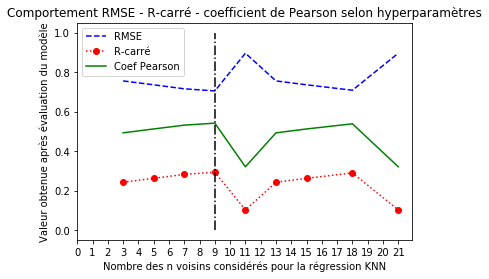

In [3]:
# On récupère les résultats pour chacun des hyperparamètres testés
resultats = validation_Custom.renvoyer_Resultats()

abscisse = np.array([3, 5, 7, 9, 11, 13, 15,18,21])

ordonnee_RMSE = np.array(resultats['RMSE'])
ordonnee_Coeff_R2 = np.array(resultats['R-carré'])
ordonnee_Coeff_Pearson = np.array(resultats['Coefficient-Pearson'])

# On trace une courbe pour chacun des indictateurs observés
plt.plot(abscisse,ordonnee_RMSE,linestyle='--',color='blue',label="RMSE")
plt.plot(abscisse,ordonnee_Coeff_R2,"b:o",color='red',label="R-carré")
plt.plot(abscisse,ordonnee_Coeff_Pearson,"-",color='green',label="Coef Pearson")

plt.plot([9, 9], [0, 1],"-.",color='black')

# On intègre les légendes et les titres des axes
plt.title('Comportement RMSE - R-carré - coefficient de Pearson selon hyperparamètres')
axes = plt.gca()
axes = axes.set(xlabel='Nombre des n voisins considérés pour la régression KNN', 
                ylabel='Valeur obtenue après évaluation du modèle')

plt.legend(loc='upper left')
pl.xticks(range(0,22))

plt.show()

### On constate que pour un nombre de voisin égal à 9, on obtient un coefficient de corrélation de Pearson égal à 0.54, qui est le maximum obtenu pour tous les hyper-paramètres testés... Ce qui corespond néanmoins à une corélation plutôt moyenne...

## Comparaison des prédictions avec une baseline naïve

In [4]:
# Import du dataset de notation du vin rouge
data = pd.read_csv('E:\Data\RawData\ClassificationVin\winequality-white.csv', sep=";")

X = data.as_matrix(data.columns[:-1])
y = data.as_matrix([data.columns[-1]])
y = y.flatten()

X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                                                    X, 
                                                                    y,
                                                                    test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

### Choix de la baseline naïve présentant les prédictions les plus proches de la régression kNN :

In [5]:
# Simulation d'une régression naïve totalement aléatoire
y_pred_random = np.random.randint(np.min(y),np.max(y),y_test.shape[0])
RMSE_random = np.sqrt(
               metrics.mean_squared_error(y_test,y_pred_random))

# Simulation d'une régression naïve avec la bibliothèque Sklearn DummyRegressor - stratégie moyenne
dumMean = dummy.DummyRegressor(strategy='mean')
dumMean.fit(X_train,y_train)
prediction = dumMean.predict(X_test)

RMSE_dumMean = np.sqrt(
               metrics.mean_squared_error(y_test,prediction))

# Simulation d'une régression naïve avec la bibliothèque Sklearn DummyRegressor - stratégie médiane
dumMedian = dummy.DummyRegressor(strategy='median')
dumMedian.fit(X_train,y_train)
prediction = dumMedian.predict(X_test)

RMSE_dumMedian = np.sqrt(
               metrics.mean_squared_error(y_test,prediction))

# Simulation d'une régression naïve avec la bibliothèque Sklearn DummyRegressor - stratégie quantile 25%
dumQuant25 = dummy.DummyRegressor(strategy='quantile',quantile=0.25)
dumQuant25.fit(X_train,y_train)
prediction = dumQuant25.predict(X_test)

RMSE_dumQuant25 = np.sqrt(
               metrics.mean_squared_error(y_test,prediction))

# Simulation d'une régression naïve avec la bibliothèque Sklearn DummyRegressor - stratégie quantile 75%
dumQuant75 = dummy.DummyRegressor(strategy='quantile',quantile=0.75)
dumQuant75.fit(X_train,y_train)
prediction = dumQuant75.predict(X_test)

RMSE_dumQuant75 = np.sqrt(
               metrics.mean_squared_error(y_test,prediction))

# Simulation d'une régression naïve avec la bibliothèque Sklearn DummyRegressor - stratégie valeur la plus fréquente
data = collections.Counter(y_test)
mode_y_test = data.most_common(1)
valeur_frequente = mode_y_test[0][0]

dumMode = dummy.DummyRegressor(strategy='constant',constant=valeur_frequente)
dumMode.fit(X_train,y_train)
prediction = dumMode.predict(X_test)

RMSE_dumMode = np.sqrt(
               metrics.mean_squared_error(y_test,prediction))

print('--------------------------------------------------------------------------------')
print('Valeur du Root Mean Squared Error pour simulation aléatoire : {}'.format(round(RMSE_random,4)))
print('Valeur du Root Mean Squared Error pour simulation dummy moyenne : {}'.format(round(RMSE_dumMean,4)))
print('Valeur du Root Mean Squared Error pour simulation dummy médiane : {}'.format(round(RMSE_dumMedian,4)))
print('Valeur du Root Mean Squared Error pour simulation dummy quantile 25% : {}'.format(round(RMSE_dumQuant25,4)))
print('Valeur du Root Mean Squared Error pour simulation dummy quantile 75% : {}'.format(round(RMSE_dumQuant75,4)))
print('Valeur du Root Mean Squared Error pour simulation dummy fréquence modale : {}'.format(round(RMSE_dumMode,4)))
print('--------------------------------------------------------------------------------')


--------------------------------------------------------------------------------
Valeur du Root Mean Squared Error pour simulation aléatoire : 1.9464
Valeur du Root Mean Squared Error pour simulation dummy moyenne : 0.9109
Valeur du Root Mean Squared Error pour simulation dummy médiane : 0.9181
Valeur du Root Mean Squared Error pour simulation dummy quantile 25% : 1.27
Valeur du Root Mean Squared Error pour simulation dummy quantile 75% : 0.9181
Valeur du Root Mean Squared Error pour simulation dummy fréquence modale : 0.9181
--------------------------------------------------------------------------------


### On constate que l'indicateur du RMSE présente la meilleure performance avec la simulation de la bibliothèque dummy en mode moyenne (le simulateur renvoie une régression toujours égale à la moyenne du dataset d'apprentissage).

### Ce que confirme le graphique suivant :

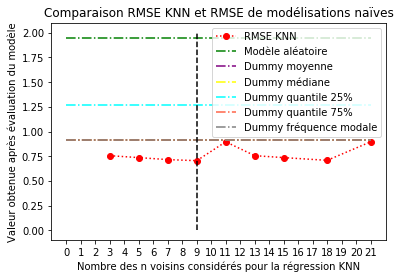

In [6]:
# On trace un graphique pour comparer résultats de RMSE et classifieurs naïfs
# On trace une courbe pour chacun des indictateurs observés
listeCouleurs = ['red',
                 'green',
                 'purple',
                 'yellow',
                 'pink',
                 'cyan',
                 'tomato',
                 'grey',
                 'goldenrod',
                 'darkkhaki']

plt.plot(abscisse,ordonnee_RMSE,"b:o",color=listeCouleurs[0],label="RMSE KNN")

plt.plot([0, 21], [RMSE_random, RMSE_random],"-.",color=listeCouleurs[1],label="Modèle aléatoire")
plt.plot([0, 21], [RMSE_dumMean, RMSE_dumMean],"-.",color=listeCouleurs[2],label="Dummy moyenne")
plt.plot([0, 21], [RMSE_dumMedian, RMSE_dumMedian],"-.",color=listeCouleurs[3],label="Dummy médiane")
plt.plot([0, 21], [RMSE_dumQuant25, RMSE_dumQuant25],"-.",color=listeCouleurs[5],label="Dummy quantile 25%")
plt.plot([0, 21], [RMSE_dumQuant75, RMSE_dumQuant75],"-.",color=listeCouleurs[6],label="Dummy quantile 75%")
plt.plot([0, 21], [RMSE_dumMode, RMSE_dumMode],"-.",color=listeCouleurs[7],label="Dummy fréquence modale")

plt.plot([9, 9], [0, 2],"--",color='black')

# On intègre les légendes et les titres des axes
plt.title('Comparaison RMSE KNN et RMSE de modélisations naïves')
axes = plt.gca()
axes = axes.set(xlabel='Nombre des n voisins considérés pour la régression KNN', 
                ylabel='Valeur obtenue après évaluation du modèle')

plt.legend(loc='upper right')
pl.xticks(range(0,22))

plt.show()

### On constate néanmoins que la médiane est relativement proche de la moyenne, ce qui dénote une dispersion plutôt resserrée sur le jeu de données... Quoiqu'il en soit notre régression Knn offre de meilleures performances en terme de RMSE que les simumations naïves, ce qui signifie que cette régression Knn apporte une plus-value en terme d'apprentissage sur les données, ce qui permet de délivrer des prédictions plus intelligentes.

### Nous choisissons donc la simulation naïve de la moyenne pour le restant de la comparaison en raison de ses meilleures performances... 

### Nous allons donc désormais superposer les prédictions de la régression Knn et celles de la prédiction naïve, afin de comparer leurs comportements... 

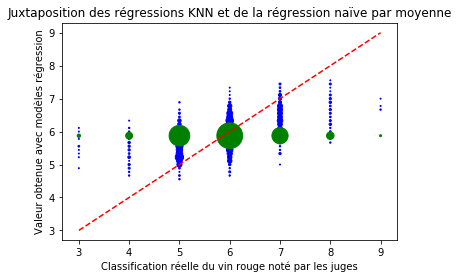

In [7]:
# On représente les points avec une régression KNN avec n_neighbor=9
# et la prédiction avec une régression naïve de type moyenne (celle-ci a la meilleure performance)
Classifieur_Custom.fit(X_train_std,y_train)
y_pred = Classifieur_Custom.predict(X_test_std)

dumMean = dummy.DummyRegressor(strategy='mean')
dumMean.fit(X_train,y_train)
prediction = dumMean.predict(X_test)

# Prédiction Knn
sizes = {} 

for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) not in sizes:
        sizes[(yt, yp)] = 1
    else:
         sizes[(yt, yp)] += 1

keys = sizes.keys()

plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
            s=[sizes[k] for k in keys], 
            color='blue')

# Prédiction naïve
sizes2 = {} 

for (yt, yp) in zip(list(y_test), list(prediction)):
    if (yt, yp) not in sizes2:
        sizes2[(yt, yp)] = 1
    else:
         sizes2[(yt, yp)] += 1

keys2 = sizes2.keys()

plt.scatter([k[0] for k in keys2], 
            [k[1] for k in keys2], 
            s=[sizes2[k] for k in keys2], 
            color='green')

# On insère la bissectrice de la régression parfaite
plt.plot([3,9],[3,9],linestyle='--',color='red')

# On intègre les légendes et les titres des axes
plt.title('Juxtaposition des régressions KNN et de la régression naïve par moyenne')
axes = plt.gca()
axes = axes.set(xlabel='Classification réelle du vin rouge noté par les juges', 
                ylabel='Valeur obtenue avec modèles régression')

# Affichage du graphique
plt.show()

### On constate donc qu'à l'exception de la classe 6, pour laquelle les prédictions de la régression Knn sont centrées autour de la moyenne, pour les autres classes, la régression Knn offrent des prédictions qui se rapprochent plus des classes réelles (classes 5 et 7 par exemple) que la baseline naïve. La régression apporte donc de l'information et permet d'améliorer la prédiction qui découlerait d'une moyenne constante. 

### Il s'avère toutefois que la régression Knn semble avoir des difficultés à offrir des prédictions cohérentes sur lesclasses excentrées (classes n° 3, 4 et 9). La régresion semble donc moins efficace sur les outliers, peut être en raison d'un apprentissage underfitté (modèle pas assez complexe)... 